# Data intelligence application
> **Filippo Colombo <br>
> Giovanni del Vecchio <br>
> Flavio Fiamingo <br>
> Leonardo Guerra** <br>

## Pricing & Advertising project

## 0. Introduction
This report aims to give an overview of the steps conducted to reach the goal of modelling the following given scenario: consider the scenario in which advertisement is used to attract users on an ecommerce website and the users, after the purchase of the first unit of a consumable item, will buy additional units of the same item in future. We will walk through the description of the specific scenario we have studied and the design choices we adopted in order to yield the optimal solution for our obejctive: to find the best joint bidding and pricing strategy.


## 1.Scenario
The real world scenario we chose to model is the exploitation of online advertising to enhance the incomes of a **coffee** seller and the consequent choice of the best price for each class of costumer. For the sake of simiplicity the costumers of the coffee website are supposed to be categorized based on a feature space described by to 2 binary features:
* Customers used to buy online
* Every day consumers
|       | Every day | Not Every day |
|-------|----------|--------------|
| **Online buyer** | C1        | C3            |
| **Not Online buyer** | C3        | C2             |


The table above shows the 3 sub-categories that distinguish the customers:
* **C1**: customers used to buy online and that consume coffee on a daily basis
* **C2**: class that includes two kinds of customers since they behave in a similar manner, that is the every day consumers that are not very accostumed to buy online and the customers that drink coffee less frequently but that buy often online
* **C3**: hard customers that are not used to buy online and that drink coffee less frequently than every day consumers

<br>

Each customers' class is characterized by:
* a stochastic **number of daily clicks** of new users as a function depending on the bid;
* a stochastic **cost per click** as a function of the bid;
* a **conversion rate** function providing the probability that a user will buy the item given a price;
* a distribution probability over the **number of times the user will come back** to the ecommerce website to buy that item by **30 days** after the first purchase.

For the aforementioned class' characteristics we have retrieved some data on similar items from the internet and with some work of averaging and adjustment the following distributions have been generated:<br><br>
**INSERT GRAPHS**<br><br>


In [1]:
from data_generators.standard_generator import StandardDataGenerator, Plotter
plotter = Plotter('src/report_data.json')

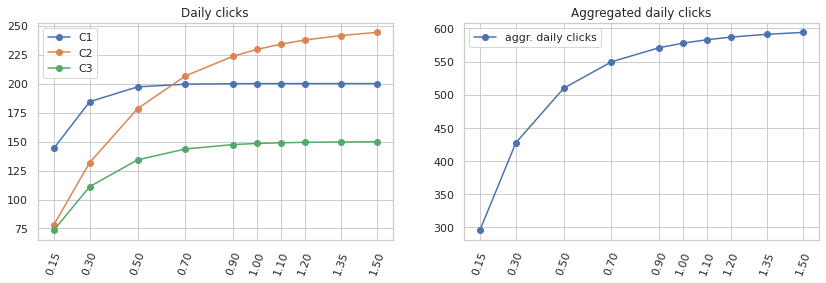

In [2]:
plotter.plot_daily_clicks(sub=True, figsize=(14,4))

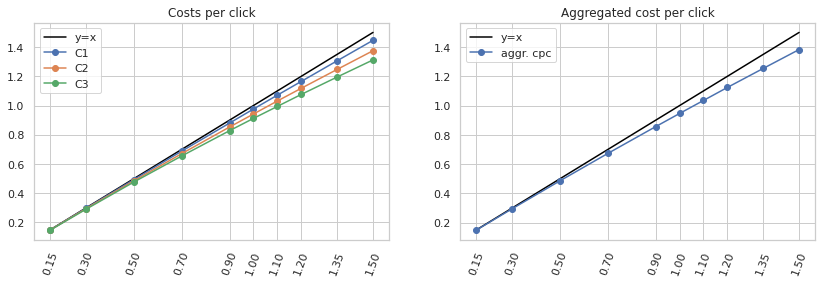

In [3]:
plotter.plot_costs_per_clicks(sub=True, figsize=(14,4))

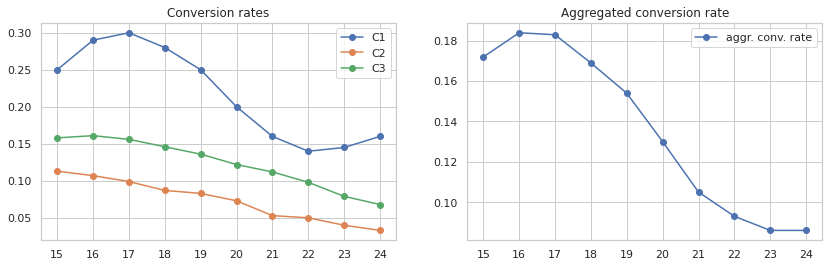

In [4]:
plotter.plot_conversion_rates(sub=True, figsize=(14,4))

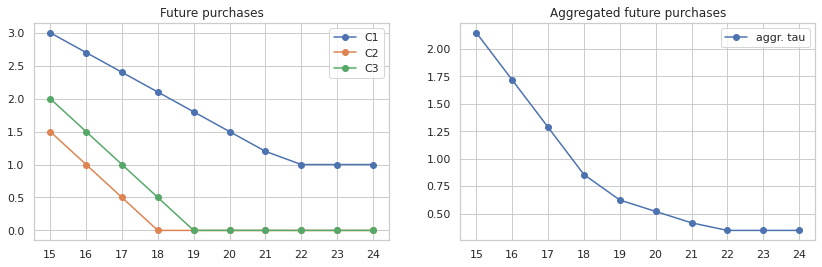

In [5]:
plotter.plot_next_purchases(sub=True, figsize=(14,4))

The data are generated by the class _StandardDataGenerator_ that handles the reading process of the parameters and values from a file in _.json_ format.<br>
In particular the number of daily clicks, the cost per click and the future purchases of the user are modelled with the following functions:
* daily clicks  : $ U_B * (1 - e^{(-f_S * x)}) $ 
* cost per click : $ C * log(1 + x/C) $ 
* future purchases : $max(L_B, -K*v(p)+P)$ 

| Variable | definition |
|---------:|:-----------|
| $x$ | bid value |
| $U_B$ | Daily clicks upper bound |
| $f_S$ | Speed factor |
| $C$ | Growth coefficient |
| $L_B$ | Future purchases lower bound |
| $K$ | Normalization coefficient |
| $v(p)$ | Price dependent value |
| $P$ | Future purchases upper bound |

## 2. Model formalization
Once we have described the scenario in which we are going to work, we need to formalize in a mathematical fashion which is our goal, how we want to achieve it and the variables that come into play.<br> 
### 2a. Assumptions
1. Every price available is associated with a margin obtained by the sale that is known beforehand. Without loss of generality we assume to have a fixed cost for the coffee production and so to use directly the margin for the pricing process<br>
2. The price _p_ for a given costumers is fixed for any future purchases<br>
3. If a customer visit again the website after a first purchase, he/she will surely buy the item again<br>
4. Ther is no budget constraint<br>
5. Auctions are not included in the modelling of the scenario nor simulated<br>
6. Every sub-campaign is asssociated with a given class of customer (i.e. context)<br>
7. The considered time horizon is of 1 year

### 2b. Offline setting
In this section the problem is formulated by mean of an objective function followed by the formalization of an algortihm to solve it. Here we make a further **assumption** of working in an **offline setting**: the values of the parameters of the problem are known. Before stating the function, the parameters with their descriptions and the notations are given in the table below.

| Variable | Description |
|---------:|:------------|
| $t$ | Time/Day  |
| $T$ | Time horizon |
| $j$ | A customer class |
| $N$ | Number of customer classes |
| $p_{j,t}$ | Price at time $t$ for the customer class $j$ |
| $c_{j}$ | Conversion rate at price $p$ for the customer class $j$ |
| $m$ | Margin obtained by the sale at price $p$ |
| $x_{j,t}$ | Bid of subcampaign $j$ at time $t$ |
| $n_{j}$ | Number of clicks of new users of subcampaign $j$, given the value of the bid $x_{j,t}$ |
| $\tau_{j}$ | Number of times the user buy again the item by 30 days after the first purchase |
| $CPC_{j}$| Cost per click for the subcampaign $j$, given the value of the bid $x_{j,t}$ |

<br><br>
Now we can formulate our objective function for finding the best **joint pricing and bidding strategy** with the goal of **maximizing the profit**:
<br><br>
> $ \underset{p_{j,t} , x_{j,t}} {\textrm{max}} \sum \limits _{t} ^{T} \sum \limits _{j} ^{N} n_{j}(x_{j,t}) \text{  } [ \text{  } c_{j}(p_{j,t}) \text{  } m(p_{j,t}) \text{  } (\tau_{j} + 1) - CPC_{j}(x_{j,t}) ] $
<br><br>

The algorithm to solve the problem could be a classiacl brute-force approach based on the following setting:<br><br>
For $t = 1$ to $T$, and for $j = 1$ to $N$ set:
> $p_{j,t}^{*}, x_{j,t}^{*} = \underset{p_{j,t} , x_{j,t}}{\textrm{arg max}} \text{  } n_{j}(x_{j,t}) \text{  } [ \text{  } c_{j}(p_{j,t}) \text{  } m(p_{j,t}) \text{  } (\tau_{j} + 1) - CPC_{j}(x_{j,t}) ]$

The values of all the parameters are known and available in $\Theta(1)$, given the assummption of an offline setting.  
Defining $X$ the total number of bids and $P$ the total number of prices, the algorithm finds the optimal values $p_{j,t}^{*}, x_{j,t}^{*}$ with time complexity: $$ \Theta(T \text{ } N \text{ } X \text{ } P) $$


### 2c. Online setting
Once the offline version of the model has been formalized and the scenario depicted, the scope of the project resides the most in solving a real case scenario that is best modelled by an **online setting**. Here we remove the previous assumption of knowing beforhand all the parameters of the distributions. This means that we have to find the best values for the price and bid, **without having full knowledge of the distributions** governing our variables. To find an approximation of the variables we have to sample values from the environment and build an increasingly-better estimation of the underlying distribution.
Each day is considered a different "round" of our problem and, as previously stated, we consider a time horizon of 1 year.<br>

##### Random Variables
In this section we list the variables of which we do not have full knowledge. These variables will be sampled at each round from a distribution in the environment. 

| Random Variable | Motivation |
|---------:|:------------|
| $CPC_{j}$| Cost per click is randomly extracted from distribution |
| $c_{j}$ | The conversion (buying an item after visiting the site) is sampled from a distribution |
| $n_{j}$| Number of new users is randomly extracted at the 'start' of each day |
| $\tau_{j}$| The number of times the user buys again is sampled from a distr. after the first purchase |

Sampling from a variable means extracting a value from a distribution with the chosen parameter.
In particular when sampling from the Conversion Rate, we sample from a _Bernoulli_ distribution. Meanwhile, when sampling from the CPC and the number of new users we sample from a _Gaussian_ distribution with the chosen mean and variance parameters. Finally, the number of future purchases are sampled from a _Binomial_ distribution.

##### Delays
The analysis of the problem lead also to consider potential delays in the feedbacks. <br>
The delay that can be considered in the given scenario is that the subsequent buys from the same user are not considered instantaneous but delayed by a certain time. For the sake of simplicity, we considered the time to be fixed to 30 days, but it can also be implemented as a random variable where the delay sampled from a probability distribution. 

| Delay | Description |
|---------:|:------------|
| $\alpha_{j}$| Delay in acquiring item again  | 

To cope with the delay issue we have chosen to draw a sample from a Binomial distribution each time a user buy the coffee on the website. This sample represents the number of time the user will come back to buy the item again. After 30 rounds from the purchase, the income of the future purchases is added to the reward linked to the strategy chosen by the algorithm in order to update the parameters.

### 2d. Algorithm
To solve the online optimization problem we use a MAB approach.
In the MAB approach the objective is to minimize the regret, defined as the cumulative difference between the reward of the clairvoyant algorithm, which always chooses the optimal arm $\mu^*$, and the reward given by the arm which we choose at a specific round $\mu$.<br> 
Each arm is described by a given value that depends on the problem we are trying to solve: 
- a bid value in case of advertising problem
- a price value for a pricing problem

The mathematical formualation of the MAB setting for the scenario is the following:
> $ \underset{p_{j,t} , x_{j,t}} \min \rho $
<br>
<br>
> $ \rho = T \cdot \mu^* - \sum_{t=0}^T \mu_t $
<br>
<br>

The rewards use the values sampled from the distributions described in the previous section and follow the formula:
<br>
<br>
> $ \mu^* = {n_{j}^*} (x_{j,t}) \text{  } [ \text{  } c_{j}^*(p_{j,t}) \text{  } m(p_{j,t}) \text{  } (\tau_{j}^* + 1) - CPC^*_{j}(x_{j,t}) ] $
<br>
<br>
$ \mu_t = {n_{j,t}} (x_{j,t}) \text{  } [ \text{  } c_{j,t}(p_{j,t}) \text{  } m(p_{j,t}) \text{  } (\tau_{j,t} + 1) - CPC_{j,t}(x_{j,t}) ] $

##### Learner
The _Learner_ class is the abstract class from which the other learner algortithms, used in the different steps of the problem, inherit the structure. The key parts of the _Learner_' stucture goes from the initialization to the update of the parameters. Once a new _Learner_ is created, variables like the number of the arms and the value related to each arm are set to the values related to the problem we are going to solve (i.e. different price values in a pricing scenario); other variables like the time _t_ and the collected _rewards_ are initialized to 0 and to an empty list respectively. \
The basic operations of the _Learner_ class reside in the _pull_arm_ method that return the best sampled arm at the specific round and the _update_ method that handle the parameters to be modified after the round has been played.

##### Environment
The _CompleteEnvironment_ class aims to simulate a real environment. Given the distributions for the sub-class parameters it returns a sample of the values needed by the _Learner_ to update the collected rewards and the related parameters. The returned values are completely transparent to the _Learner_ that can retrieve the different values of $CPC_{j}$, $c_{j}$, $n_{j}$, $\tau_{j}$. This values are sampled from the distributions retrieved thanks to the _Standard__Generator_ class that reads them from the _json_ file.<br>

### 2e. Approach
The approach followed to solve our goal of finding the best joint pricing/bidding startegy is a step by step approach divided into **pricing campaign** and **advertising campaign** separated at first. Both campaigns start from the trivial scenario in which some paramaters are known beforhand and **fixed** and the optimization problem is solved by considering the **aggregate** classes. We then continue by integrting the **context** structure that handles the optimization problem for each subclass and finally we intergrate the different campaigns to solve the optimization problem in its entirety.
Further details on the learners, environment and other key classes to solve the problem will be given in the following sections.

In [6]:
from utils.tasks.complete_task import CompleteTask

## 3. Pricing campaign

The objective in the pricing scenario is to learn the optimal price of our product to maximize the total revenue.\
In an everyday scenario a seller might try to negotiate the price of a good, trying to sell it for the maximum price at which the buyer would buy it. The seller while performing his job exploits the knowledge he has about the customers to increase his profit. 
The same can be done in our scenario, where we'll use reinforcement learning algorithms that will learn the optimal price of our product.
To explain how this algorithms work we need to introduce the concept of demand curve.
### 3a. Demand Curve
The demand curve is a function that maps the price of a good and the quantity of that good demanded at that price.
A _market demand curve_ can be used to model the price-quantity relationship for all consumers in a particular market.
The price-quantity relationship can also be expressed putting on the x-axis the price and on the y-axis the probability that a user will buy the good at that price, a function also defined as _conversion rate_. \
As shown in the introduction, we divide our customer using two binary features and we identify 3 different classes.
For each class we have a different conversion rate:
- __Class C1__: these are users that buy every day coffee online so they'll have an overall higher conversion rate, especially for the low prices. We  assumed that some users of this category might be interested in finer types of coffee with a high price. This is expressed with a strongly decreasing demand curve, which has only a slow increase at the end.
- __Class C2__: these mixed class includes users that either buy online but are not everyday consumers or that buy frequently coffee but are not accustomed to buying online. These kind of users are the one with the lowest interest in the product and this is shown by a overall low conversion rate. The curve is pretty much linearly decreasing with a low slope.
- __Class C3__: In this class there are the users that usually don't buy online and that aren't used to buy coffee. We tought that these kind of users might be more curious to try the product so the conversion rate is overall higher w.r.t. the class C2. The trend is again linearly decreasing.

Here it is the visual representation of the conversion rates:

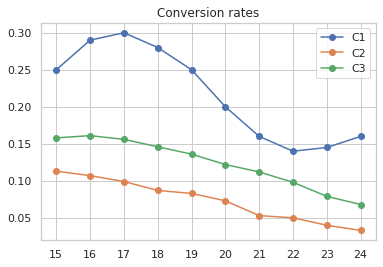

In [7]:
plotter.plot_conversion_rates()

In the next section we will not discriminate the users on their class, so the _aggregate conversion rate_ must be computed as a weighted mean over the 3 conversion rates using as weights the fractions that represent the number of users belonging to the class over the total number of users.
The ending result is the following:

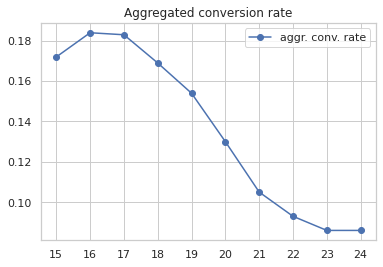

In [8]:
plotter.plot_conversion_rates(aggregate=True)

### 3b. Scenario
We'll start by considering the **aggregate** case, where we do not consider the differences between the festures of the various users.
Another important thing to consider is that in the pricing scenario we will assume all the variables depending on the bid as fixed.
Let's now reconsider our goal, which is to maximize the total revenue.
To do so we need to find the optimal price, which is the one that maximizes the profit  $n_j*(m_{p_j}*(\tau_{j}+1)*c_j-CPC{j})$.
Given that the number of clicks $n_j$, the margin $m_{p_j}$ and the cost per click $CPC{j}$ all depend on the bid and so are fixed in this scenario, our objective will be to find a proper estimation of the conversion rate $c_j$ and of the variable $\tau_{j}$and we'll do so through an iterative learning process. 
The main elements of our simulation are:

- __The Environment__
- __The Learner__



### 3c. Environment

The environment simulates the market in our implementation. It is a clairvoyant entity that knows a priori all the distributions of the various parameters related to the users, that are dependent on the bid and on the price. In the basic pricing scenario the bid is fixed so parameters depending on it, such as the cost per click $CPC_{j}$ and the number of clicks $n_{j}$, can be directly computed. 
The conversion rate $c_{j}$  and the number of times the user will buy again in the next 30 days $\tau_{j}$ are instead dependent on the price, so they will be computed day by day given the price $p$ chosen by the learner. \
Each day the environment iterates over the number of clicks and according to the conversion rate it samples the outcome of their decision (to buy or not to buy the product), communicating to the learner the class to which they belong.\
The environment is perceived from the outside as a black box and the only informations obtainable by the learner are the daily reward (i.e. a list composed by all the users' outcomes and their associated $CPC_{j}$) and the number of additional purchases per day that is computed using $\tau_{j}$. It is important to notice that the latter is an information that will only be shared with the learner 30 days from when the purchase happened.


### 3d. Learner

The learner's task is to find the optimal price of the product by interacting with the environment. This mechanism can be implemented through a Multi-Armed Bandit (MAB) algorithm, whose final aim is finding the arm that maximizes the reward given by the enviroment. The pricing problem can indeed be formulated as a bandit problem by associating to each arm a price.
Although the price $p$ is a continous variable, we picked 10 prices in the range [15,24] to face the problem of having a discrete number of arms.
There are many pratical implementations of the MAB algorithm, among those there are the Upper Confidence Bound Bandit Algorithm (UCB) and the Thompson Sampling Algorithm (TS).
Here is shown how they work in a general case.
#### UCB
First off we assume that each arm is a Bernoulli in [0,1] with unknown mean.Every arm is associated with an upper confidence bound. At every round the arm with the highest upper confidence bound is chosen which will then be updated according to the reward of the arm given by the environment. 

Here are the steps in detail, with $x_a$ being the empirical mean and n_a the number of samples of arm $a$ at time $t$:
- 1: Play once every arm $a ∈ A$
- 2: At every time $t$ play arm $a_t$ such that $a_t ← arg max_{a∈A} \{x_a + \sqrt{\frac {2 log(t)} {n_a(t − 1)}} \} $



#### Thompson Sampling
Once again the arms are Bernoulli in [0,1] with unknown mean. For every arm, we have a prior (beta distributions) on its expected value. We will choose the arm according to the prior and update the prior according to the observed realization.

The algorithm works by repeating these steps until convergence, with $ℙ(μ_a = θ_a)$ being the prior on the expected value of $X_a$ and $θ_a$ the variable of the prior:
- 1: At every time step $t$, for every arm $a$ $θ_a ← Sample (ℙ(μ_a = θ_a))$
- 2: At every time $t$ play arm $a_t$ such that $a_t← arg max_{a∈A} \{θ_a\}$
- 3: Update the Beta distribution of arm as $(α_{a_t}, β_{a_t}) ← (α_{a_t}, β_{a_t}) + (x_{a_t,t},1 − x_{a_t,t})$ 


We decided to implement both of them making some modifications on the functioning of the algorithms. 
In our particular scenario there is indeed a big difference when we want to compute the arm to be pulled.
In the general case the arm to be chosen is the one  whose expected value is maximum. This doesn't happen in our scenario, where the value of the arm represent an approximation of the conversion rate $c_j$. What we want to maximize is not the conversion rate itself but the value $m_{p_j}*(\overline{\tau_{j}}+1)*c_j$. \
So in UCB the empirical mean that is calculated based on the outcome of the enviroment will approximate the conversion rate and the updated condition is:
> $a_t ← arg max_{a∈A} \{x_a*m_{p_j}*(\overline{\tau_{j}}+1) + \sqrt{\frac {2 log(t)} {n_a(t − 1)}} \} $

The same happens in the TS approach where the beta distribution approximates the conversion rate and the new condition to choose the arm to play is:
> $a_t← arg max_{a∈A} \{θ_a*m_{p_j}*(\overline{\tau_{j}}+1)\}$

Notice that in this way, the MAB will estimate the conversion rate associated to each price, and the arm to be pulled is not the one associated to the largest estimated conversion rate. This approach is possible beacuse the variables that contribute to the computation of the reward are either known a-priori (the margins $m_{p_j}$) or can easily be estimated (the number of future purchases $\tau_{j}$ associated to each arm).
Indeed the variable $\overline{\tau_{j}}$ is estimated by averaging, for each price (arm), the number of times the users come back to buy. \
To sum it up, at each time step $t$ the algorithms select the arm with the highest expected reward. The environment then returns the daily reward of the arm selected and, if available, the number of additional purchases of the day $t-30$ . The expected rewards of the arms are recomputed and the variable $\overline{\tau_{j}}$ of the arm selected is updated computing it as an incremental mean.


### 3e. Performance

The performances are evaluted by performing some tests on the algorithm presented.
In our approach we decided to keep a fixed price for each day, so the arm to be pulled will be determined for the first user of the day and for the other users we will propose the same price. In this way we'll have the same arm pulled for all the users of a day.\
Furthermore the regret will be computed considering as optimal the maximum reward of the aggregated model. This solution doesn't take into consideration the differences between the different classes. Nevertheless the algorithm in this scenario isn't expoliting the differences between the different classes so the best way to show its functioning is using the approach shown above.
It's also important to notice that the reward is in expectation with respect the randomization of the approach.



In [9]:
task = CompleteTask(data_src="src/report_data.json", name="step3")
task.load("simulations_results/result_step3_final.zip")

Simulation's result loaded from `simulations_results/result_step3_final.zip`.


Here the regret graph is presented. The regrets increases linearly until, after around 30 days, the learner starts collecting the information about $\overline{\tau_{j}}$. This happens because till that point the actual reward can't be calculated and instead we have an understimaded value. From that point on the value of  $\overline{\tau_{j}}$ is effectively estimated and the regret decreases significantly.

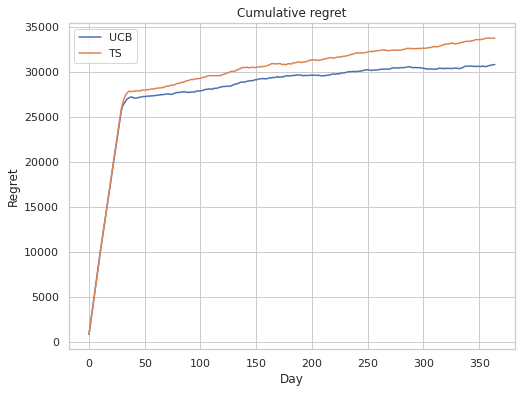

In [10]:
task.plot(0, figsize=(8,6))

As seen also by the reward graph, after around 30 days the optimal arm is almost always selected.

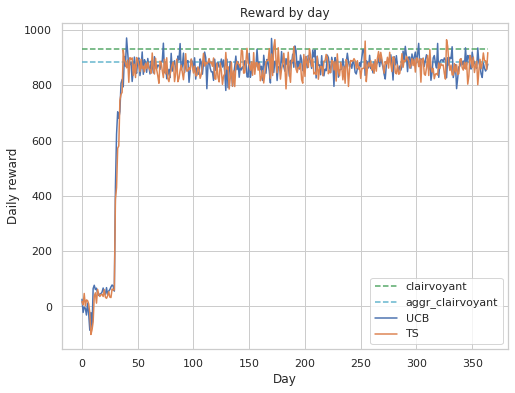

In [11]:
task.plot(1, figsize=(8,6))

## 4 Context generation in pricing

Up to this point we considered users as they belonged to a unique class, disregarding the differences and peculiraties between the different classes of users. The algorithms used didn't indeed discriminate between the different classes and as a result it learned throught time the aggregated conversion rate $c$ and the aggregated $\tau$. We should look for a method to encode the different features in our algorithm in order to capture their differences and improve even more our performances. 
To do so we need first to introduce the concept of context.



### 4a. Context
As shown in the introduction every user is characterized by two binary features, which divides the feature subspace in $2^{2}=4$ parts.
By assigning specific values to the features we can define the classes of our users. In this way for example we defined class C1 as the the class with features _Online-Buyer=True_ and _Every-Day=True_. \
We define the context as a partition of the feature subspace according to some specific values of the features. A context might be a bigger feature subspace than a class and can group together many classes. In our case a context could be defined by _Online-Buyer=True_ and include both users belonging to C1 and to C2. \
Dividing the feature subspace in context might be beneficial for our approach to lighten the computational charge and fasten the calculations.

### 4b. Context generation
The number of possible partition(i.e. possible contexts) is although double exponential and we can't evaluate all of them. We need therefore an heuristic to guide us in our search throughout the feature space.
We found a possible solution in the greedy context generation algorithm, that works as follow:
1. For every feature
 * Evaluate the value after the split
3. Select the feature with the maximum value if larger than the non split case

So this algorithms looks for features that have not been already expanded in the current subspace, for everyone of them defines a value representing how valuable is the split on that feature and selects, if it exists, the feature with the maximum value.
At the end of the computation the result is a feature tree whose branches are the binary values of the features on which we splitted and the nodes are the different contexts.
This approach is said to be greedy cause it looks for the most promising feature, without exploring all the different feature trees that perform other feasible splits.

### 4c. How do we perform the evalutation?
The evaluation is performed on the basis of what is defined as _split condition_. \
The split condition is formally defined as  
$$\underline{p_{c_1}}*\underline{μ_{a{c_1}^*,c_1}}+\underline{p_{c_2}}*\underline{μ_{a{c_2}^*,c_2}}\geq{\underline{μ_{a{c_0}^*,c_0}}}$$ \
with $\underline{p_{c_x}}$
being the probability that context $C_x$ occurs and $\underline{μ_{a{c_x}^*,c_x}}$ being the lower bound on the best expected reward for context $C_x$.
The two contexts $C_1$ and $C_2$ are the context that would be generated by the split and context $C_0$ is the context we are analyzing. 
The choice of the lower bound depends on the distribution. Having a finite distribution (Bernoulli) we used the Hoeffding bound
that is computed as $\overline{x} −\sqrt{\frac{log(δ)}{\mid2Z\mid}}$ where $δ$ is the confidence and $Z$ is the set of data.
The lower bound has been introduced to avoid splitting on conditions that do not significantly improve the performance.
The higher the confidence the lower will be the probability of choosing to split.



### 4e. Our implementation
In our scenario we implemented the above algorithms in the exact same way as it is described above.
The environment is the exact same of the one of the previous point and the only differences are in the learner. \
Indeed now our program starts from a parent node to which it corresponds a learner.
After a starting date $d$ the split condition is evaluated and, if the split is performed, two nodes corresponding to the partitions of the selected feature are generated. 
These two nodes will be two new learners themselves and they will be trained on the data available till that date, using only the data that complies with the constraint of the node's feature. \
Every node generated keeps track of the features that have been already expanded and the feature that are yet to be.
With a frequency $f$ new splits will be evaluated on the leaf nodes of the current graph until the time ends or the feature subspace is fully explored. \
The constraint on the starting date has been introduce to overcome the starting period of 30 days in which the learner doesn't fully capture the situation.
Every node will save the history of rewards until a split occurs in such a way that the rewards over all the time arc we are analazying can be computed using a top-to-bottom approach on the tree of learners.

### 4f. Performance evaluation
As in the aggregated scenario the arm to be pulled (i.e. the price) is chosen at the start of the day.
What differs instead is that now the regret is computed using as optimal the reward of the __disaggregated__ model. This reward will be computed using the $c_j$ and $\tau_j$ belonging to the class j. \
As shown in the reward plot the context generator is much more powerful compared to the previous model as it even exceeds the clairvoyant reward in the aggregated case. \
This is a proof of the upgrade in performances obtainted by following this approach.

In [12]:
task = CompleteTask(data_src="src/report_data.json", name="step4")
task.load("simulations_results/result_step4_final.zip")

Simulation's result loaded from `simulations_results/result_step4_final.zip`.


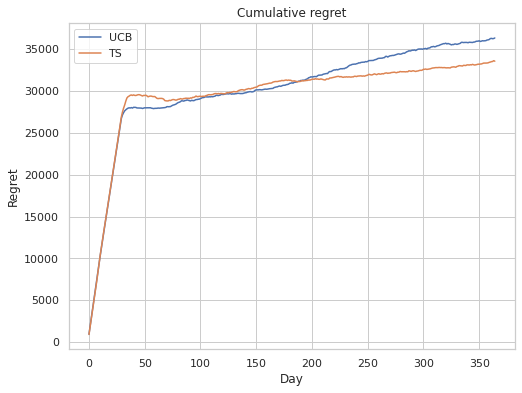

In [13]:
task.plot(0, figsize=(8,6))

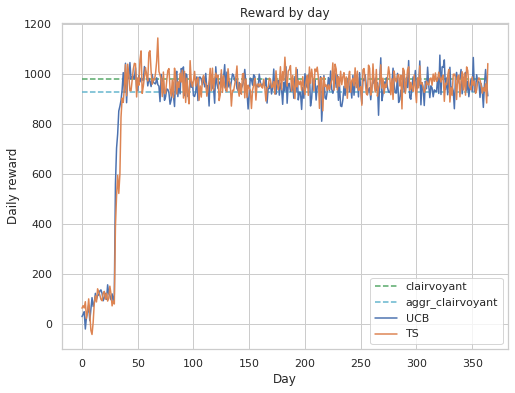

In [14]:
task.plot(1, figsize=(8,6))

Here we report the performance of the context generator when applied alongside the Thompson Sampling alogrithm.

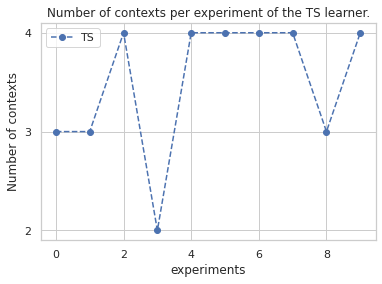

In [15]:
task.plot(2, figsize=(6,4))

## 5. Advertising campaing
Advertising is a marketing comunication that aim to promote to sell a product. In our specific scenario, advertising campaign is carried out by means of media and web channels. Given our assuptions, we are endowed of an unlimited budget and we do not need to model and deal with the auction mechanism that regulate the advertiser and auctioner correlation. For this reason we will focus only on the choice of the best bid to maximize the profit and optimize the objective function. 


### 5a. Scenario
In the advertising scenario we start by studying the **aggregate** case, that is, we do not distinguish between different classes of users. Moreover, since our optimization function includes some variables that depends on the price, we will assume it to be fixed to a given value chosen a priori. This results in having a fixed value also for the variables or the parameters of the distributions that depend on the price such as the conversion rate, the margin and the future purchases. To sum up, the goal of the advertising problem in the initial setting is to **maximize the profit with respect to the cost per click $CPC$ and the number of clicks $n$** depending on the chosen bid.

### 5b. Environment
The structure is more or less the one described in the previous sections. The only difference pertains the returned values as _reward_ to the learner of the advertising problem. The round played by the environment resides mostly in the sampling of the $CPC$ and the number of new users that are lured to click on the ads. The variables depending on the price are, as stated before, fixed.

### 5c. Learner
In this scenario the learners are modelled in order to try out different bid values in a MAB setting. Each arm of the learners is assigned to a different bid value. In our specific problem there will be 10 different bids; discretized to overcome the fact that it should be a continuos variable. For our problem we have chosen to initially use two different learner models: _Gaussian Thompson Sampling_ (GTS) and _Gaussian Process Thompson Sampling_ (GPTS).

##### GTS
For a detailed description of the _Thompson Sampling Algorithm_ see the _Learner_ section in the _Pricing campaign_ part. The only difference with respet to a classical TS approach is the use as a prior and as arms' distribution a _Gaussian_ distribution.

##### GPTS
The _Gaussian Process Thompson Sampling_ is based, as the name suggests, in the use of Gaussian Processes. Gaussian Processes are a generic supervised learning method designed to solve regression and probabilistic classification problems. GP models a set of random variables such that they all have a multivariate normal distribution. In particular our _GPTS Learner_ exploit a Gaussian Process regressor since it is trying to model the income based on the rewards yielded by the environment that depends on the arm chosen by the GPTS. A Gaussian Process is completely defined by its mean and its covariance. Since we do not have any prior information we assumed to have _zero_ mean and the covariance given by the squared exponential kernel function $k(x,x')$:
> $k(x,x') = \theta^2 e^{-\frac{(x-x')^2}{2l^2}}$

where:
* $l$ is the _lenghtscale_
* $\theta$ is the _scale factor_

The optimal value of the 2 hyperparameters have been found by maximization of the marginal likelihood of the fit process. Meanwhile the ranges for the hyperparameters has been set on an exeprimental basis. The fit process is performed each time a new observations is retrieved from the environment. In this way the GPTS manages to reduce the uncertainty of its estimations.

##### Penalty
Both the learners are equipped with a mechanism that penalizes the arms that are too "risky". The learners avoid the arms that return an expected neagative value beyond a certain probability that we have fixed to 20%. To prevent the learners to get stucked in the initial phase (since each arm overcomes the threshold given the initial values), the algorithm starts by performing an explration phase of the arms available in order to have some information on the outcome of the pulling process.

### 5d. Performance
To evaluate the performance of our algorithms we decided to perform several tests to assess the quality of the solution proposed. The number of experiments performed for each run has been tuned in order to yield a smooth line for the regret but taking into account the computational intensity of the GPTS. \
Below can be seen, in order of appearance, the graphs for the aggregated case that represent the regret and the reward during the given time horizon of 365 days.

In [16]:
task = CompleteTask(data_src='src/report_data.json', name='step5')
task.load('simulations_results/result_step5_final.zip')

Simulation's result loaded from `simulations_results/result_step5_final.zip`.


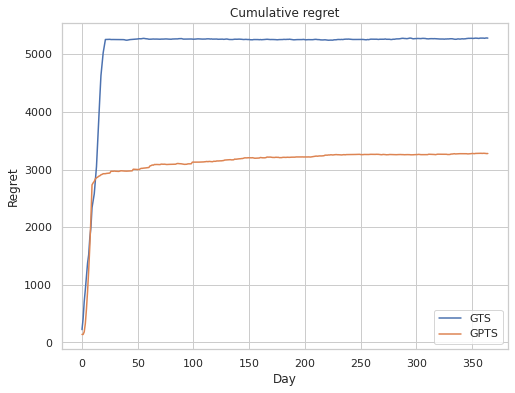

In [17]:
task.plot(0, figsize=(8,6))

The graph underlines the power of the _GPTS_ with respect to the _GTS_. However both of them reach a very good performance in choosing th optimal arm.

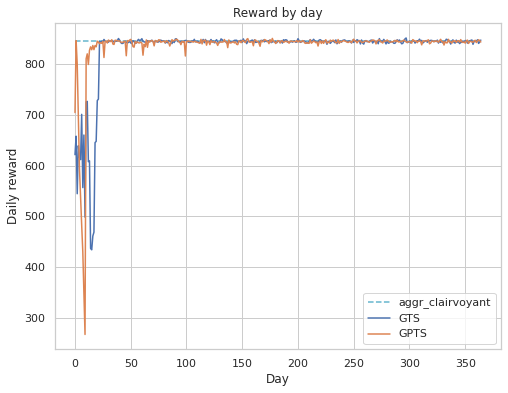

In [18]:
task.plot(1, figsize=(8,6))

It can be seen that both learners reach a very good performance after the first 30 days with a very low uncertainty. The strange behavior in the first rounds is due probably due to the exploration phase needed to use the penalty for negative reward arms.

## 6. Pricing and Advertising
In this last section we try to reach our starting goal. In order to achieve our objective we need to combine the work done on the 2 different Pricing and Advertising campaigns. One more time, we start by studying the simpler case in which we do not discriminate among the customers' classes, that is, we begin by approaching the aggregate case. Finally we will introduce the context to retrieve the best joint bidding/pricing strategy in our scenario. From now on we will use only the _GPTS_ for the advertising problem and the _TS_ for the pricing problem since they perform well in the joint setting.

### 6a. Scenario


We've explained how the two different approaches of Pricing and Advertising work on their own, considering respectively the parameters depending on the bid and on the price as fixed in the two scenarios.
However our initial goal,as stated in the introduction, was to find the optimal joint pricing and bidding strategy to maximize the profit.
Our objective in this chapter will be to propose an integration of the two approaches to try to find a solution for this problem in the aggregate and contextual settings.


### 6b. Aggregate
The main idea behind our solution is to try to manage separately the two problems of Pricing and Advertising so that we can reuse the algorithms previously implemented for the two scenarios.
We will then use the two bandits in a modular way: interacting one another by commuincating the necessary sampled data. In fact, the _JointLearner_ class works as a container for the two instances of _GPTS_ for the advertising part and _TS_ for the pricing part. The two learners separetly choose the arm to pull at each round and communicate each other the sampled variables retrieved by the environment. At the end of the day, both the learners update their parameters according to the profit computed with respect to the joint valued sampled from the environment.
Let's see more in detail how this works:
#### Advertising
On the first iteration (on the first day) we start our program with prefixed values of $c_{agg}$ and $\tau_{agg}$.
This parameters are fed as input to the Advertising-Bandit who will then set the values of the two parameters. 
The Advertising-bandit then operates as stated in the Advertising scenario, having as fixed the parameters depending on the price and producing as output the arm of the optimal bid and the parameters $n_{agg}$ and $CPC_{agg}$ that are dependant from it.
Now the parameters of the bid for the current day are set.
#### Pricing
We now set the parameters $n_{agg}$ and $CPC_{agg}$ as an input for the pricing.
The number of users $n_{agg}$ will represent how many users clicked on our ad for the current day and the $CPC_{agg}$ the cost for every click.
The Pricing-bandit exactly as the Advertising-bandit will set the value of the parameters and will choose the price of the day (the arm to be pulled) generating, for each user, their outcome, namely saying if they bought or not at a specific price $p$ the product having seen the ad with bid $b$.
At the end of the day the Pricing-bandit return the values $c_{agg}$ and $\tau_{agg}$ of the arm that has been pulled and will feed them to the Advertising-Bandit in the next iteration.
This process will be repeated until our time horizion ends. 


#### Perforamnce Evaluation
Once again we find ourselves in the aggregated scenario. The rewards will be calculated upon the rewards found in the Pricing-bandit.

In [19]:
task = CompleteTask(data_src='src/report_data.json', name='step6')
task.load('simulations_results/result_step6_final.zip')

Simulation's result loaded from `simulations_results/result_step6_final.zip`.


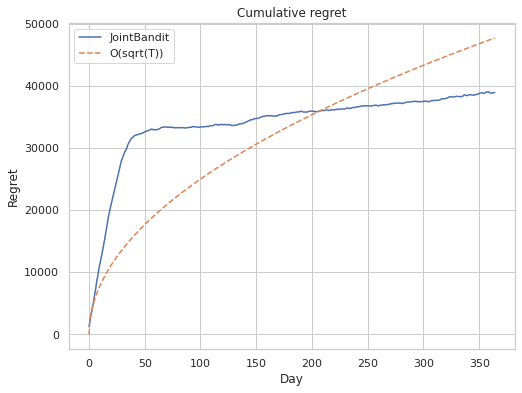

In [20]:
task.plot(0, figsize=(8,6), logn=True)

In the graph has been drawn a $\sqrt{T}$ plot to highlight the sublinear behavior of the regret once the learner has found the optimal arm.

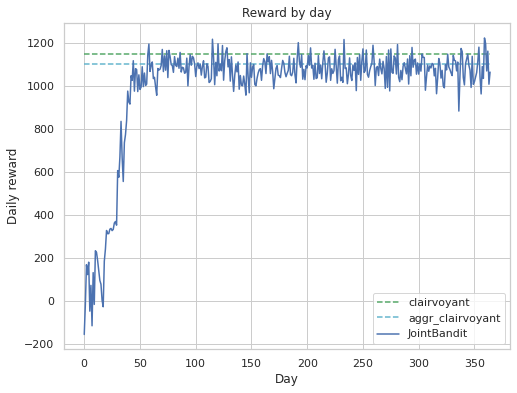

In [21]:
task.plot(1, figsize=(8,6))

### 6c. Context scenario
Following the modular setting that we have approached thruogh the entire work, we now need to integrate the context to the joint scenario. To solve our starting goal for each subclass of customers we exploit the _JointLearner_ presented before enabling the pricing sub-learner to distinguish among different customer category. The interaction mechanism remains the same as described above in 6b but the contextual behavior of the Pricing-bandit. That is, once the GPTS has pulled the bid for the given round, the environment will return the related variables $CPC_j$ and $n_j$ with respect to the context generated. This values, together with the once related to the pricing campaign, will generate the disaggregate reward that the _TS_ for pricing will use in order to update the parameters of the context. The split condition remains dependent on the pricing parameters, but contrary to the previous case, the bidding related variables will depend on the context too.

#### Performance evaluation


In [22]:
task = CompleteTask(data_src='src/report_data.json', name='step7')
task.load('simulations_results/result_step7_final.zip')

Simulation's result loaded from `simulations_results/result_step7_final.zip`.


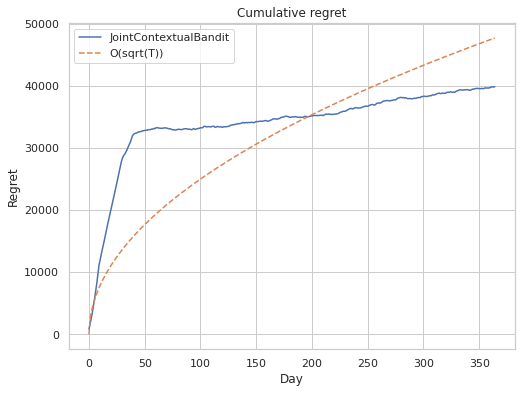

In [23]:
task.plot(0, figsize=(8,6), logn=True)

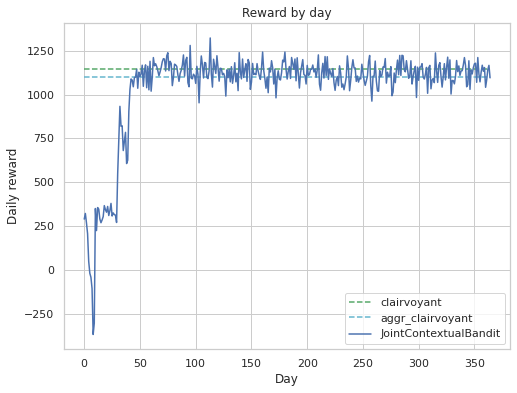

In [24]:
task.plot(1, figsize=(8,6))

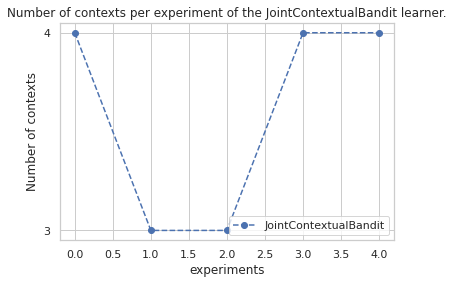

In [25]:
task.plot(2, figsize=(6,4))

## 7 Conclusion
In this report we have illustrated and defined our setting and design choices to solve the problem of the given scenario. In an incremental way we have initially set up our problem by formalizing the objective function and all the related variables. After stating the needed assumptions, we have defined a high level view of the algorithm we have build to find the solution of a joint pricing/bidding strategy. Step by step we have draw up the different Pricing and Advertising campaigns starting from the aggregated case and then performing experiments whith the context related to the customers. Finally we have joint the _GPTS_ and _TS_ for pricing to find the best bid/price couple. Once again starting from the aggregated case and then by distinguish among classes. In each section the experiment related graphs of regret and reward has been plotted to assess the quality of our algorithms.